In [1]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("Transforms ready")


Transforms ready


In [2]:
from torchvision.datasets import ImageFolder
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

train_dataset = ImageFolder(
    os.path.join(DATA_ROOT, "train"),
    transform=train_transform
)

val_dataset = ImageFolder(
    os.path.join(DATA_ROOT, "val"),
    transform=val_test_transform
)

print("Train:", len(train_dataset), "| Val:", len(val_dataset))


Train: 5216 | Val: 16


In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))


Train batches: 326 | Val batches: 1


In [4]:
import torch

model.eval()

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
val_accuracy = correct / total

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


NameError: name 'model' is not defined

In [5]:
print(
    "train_dataset:", "train_dataset" in globals(),
    "| train_loader:", "train_loader" in globals(),
    "| val_loader:", "val_loader" in globals(),
    "| model:", "model" in globals()
)


train_dataset: True | train_loader: True | val_loader: True | model: False


In [6]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model = model.to(device)

print("Model ready")


Model ready


In [7]:
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

sum(p.requires_grad for p in model.parameters()), len(list(model.parameters()))


(2, 364)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.7429, 0.2571]).to(device)
)

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-4
)

print("Loss and optimizer ready")


Loss and optimizer ready


In [9]:
model.eval()

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
val_accuracy = correct / total

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss: 0.6953
Validation accuracy: 50.00%


In [10]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

test_dataset = ImageFolder(
    os.path.join(DATA_ROOT, "test"),
    transform=val_test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Test samples:", len(test_dataset))
print("Test batches:", len(test_loader))


Test samples: 624
Test batches: 39


In [11]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix (rows=true, cols=pred):
[[229   5]
 [390   0]]

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.37      0.98      0.54       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.37       624
   macro avg       0.18      0.49      0.27       624
weighted avg       0.14      0.37      0.20       624



In [12]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("Transforms updated (no horizontal flip).")


Transforms updated (no horizontal flip).


In [13]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

train_dataset = ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_transform)
val_dataset   = ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=val_test_transform)
test_dataset  = ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=val_test_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train/Val/Test:", len(train_dataset), len(val_dataset), len(test_dataset))
print("Batches:", len(train_loader), len(val_loader), len(test_loader))


Train/Val/Test: 5216 16 624
Batches: 326 1 39


In [14]:
# Freeze everything first
for p in model.parameters():
    p.requires_grad = False

# Unfreeze classifier
for p in model.classifier.parameters():
    p.requires_grad = True

# Unfreeze last block + final norm
for p in model.features.denseblock4.parameters():
    p.requires_grad = True
for p in model.features.norm5.parameters():
    p.requires_grad = True

trainable_params = sum(p.requires_grad for p in model.parameters())
total_params = sum(1 for _ in model.parameters())
print(f"Trainable parameter tensors: {trainable_params} / {total_params}")


Trainable parameter tensors: 100 / 364


In [15]:
model.train()

EPOCHS = 3
for epoch in range(EPOCHS):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - train loss: {epoch_loss:.4f}")


Epoch 1/3 - train loss: 0.5246
Epoch 2/3 - train loss: 0.3527
Epoch 3/3 - train loss: 0.2872


In [16]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix [ [TN FP] [FN TP] ]:")
print(cm)


Confusion matrix [ [TN FP] [FN TP] ]:
[[185  49]
 [ 19 371]]


In [17]:
TN, FP = cm[0]
FN, TP = cm[1]

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"Sensitivity (Pneumonia recall): {sensitivity*100:.2f}%")
print(f"Specificity (Normal recall): {specificity*100:.2f}%")


Sensitivity (Pneumonia recall): 95.13%
Specificity (Normal recall): 79.06%


In [18]:
import torch

torch.save(model.state_dict(), "densenet_cxr_pneumonia.pt")
print("Model saved")


Model saved


In [19]:
training_info = {
    "epochs": 3,
    "final_train_loss": 0.2872,
    "test_confusion_matrix": [[185, 49], [19, 371]],
    "sensitivity": 0.951,
    "specificity": 0.791
}

torch.save(training_info, "training_info.pt")
print("Training metadata saved")


Training metadata saved


In [20]:
import os
print(os.listdir())


['.bash_history', '.cache', '.git', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.kaggle', '.matplotlib', '.vscode', '.zenmap', '02_data_loading.ipynb', 'AppData', 'Application Data', 'chest-xray-pneumonia.zip', 'Contacts', 'Cookies', 'densenet_cxr_pneumonia.pt', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'medical_ai_diagnosis', 'mentalmentor', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{1a6a121f-c842-11f0-8444-484d7eee0495}.TxR.0.regtrans-ms', 'NTUSER.DAT{1a6a121f-c842-11f0-8444-484d7eee0495}.TxR.1.regtrans-ms', 'NTUSER.DAT{1a6a121f-c842-11f0-8444-484d7eee0495}.TxR.2.regtrans-ms', 'NTUSER.DAT{1a6a121f-c842-11f0-8444-484d7eee0495}.TxR.blf', 'NTUSER.DAT{1a6a1220-c842-11f0-8444-484d7eee0495}.TM.blf', 'NTUSER.DAT{1a6a1220-c842-11f0-8444-484d7eee0495}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{1a6a1220-c842-11f0-8444-484d7eee0495}.TMContainer0000

In [21]:
import torch

torch.save(model.state_dict(), "densenet_cxr_pneumonia.pt")
print("Model weights saved")


Model weights saved


In [22]:
import os
print("densenet_cxr_pneumonia.pt" in os.listdir())


True


In [1]:
import os

data_dir = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr"a

print("Directory exists:", os.path.exists(data_dir))
print("Contents:", os.listdir(data_dir))


Directory exists: True
Contents: ['chest_xray']


In [2]:
import os

data_dir = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray"

print("Directory exists:", os.path.exists(data_dir))
print("Contents:", os.listdir(data_dir))


Directory exists: True
Contents: ['__MACOSX']


In [3]:
import os

data_dir = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr"

print("Directory exists:", os.path.exists(data_dir))
print("Contents:", os.listdir(data_dir))


Directory exists: True
Contents: ['chest_xray']


In [4]:
import os

data_dir = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray"

print("Directory exists:", os.path.exists(data_dir))
print("Contents:", os.listdir(data_dir))

Directory exists: True
Contents: ['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [6]:
import os

base = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"
print(os.listdir(base))


['.DS_Store', 'test', 'train', 'val']


In [7]:
import os

base = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"
print(os.listdir(base))


['test', 'train', 'val']


In [8]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Transforms defined successfully")


Transforms defined successfully


In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os


In [3]:
DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")

print(os.listdir(DATA_ROOT))


['test', 'train', 'val']


In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])


In [6]:
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset  = ImageFolder(root=test_dir, transform=val_test_transform)


In [7]:
print("Class names:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)


Class names: ['NORMAL', 'PNEUMONIA']
Class to index mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Train samples: 5216
Validation samples: 16
Test samples: 624


In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [11]:
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)
print("Unique labels in batch:", labels.unique())


Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])
Unique labels in batch: tensor([0, 1])


In [1]:
import torch
import torch.nn as nn
from torchvision import models


In [2]:
model = models.densenet121(pretrained=True)


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\dell/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:05<00:00, 5.75MB/s]


In [3]:
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)


In [4]:
for param in model.features.parameters():
    param.requires_grad = False


In [5]:
print(model)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [7]:
model = model.to(device)


In [8]:
import numpy as np

labels = [label for _, label in train_dataset.samples]
class_counts = np.bincount(labels)
print("Class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
print("Class weights:", class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


NameError: name 'train_dataset' is not defined

In [9]:
from torchvision.datasets import ImageFolder
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")

train_dataset = ImageFolder(root=train_dir, transform=train_transform)


NameError: name 'train_transform' is not defined

In [10]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [11]:
from torchvision.datasets import ImageFolder
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

train_dir = os.path.join(DATA_ROOT, "train")

train_dataset = ImageFolder(root=train_dir, transform=train_transform)


In [12]:
import numpy as np
import torch

labels = [label for _, label in train_dataset.samples]
class_counts = np.bincount(labels)
print("Class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
print("Class weights:", class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


Class counts: [1341 3875]
Class weights: [0.74290644 0.25709356]


In [13]:
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


In [14]:
trainable = sum(p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())

print(f"Trainable parameters: {trainable} / {total}")


Trainable parameters: 2 / 364


In [15]:
model.train()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
running_loss = 0.0

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

epoch_loss = running_loss / len(train_loader)
print(f"Training loss (1 epoch): {epoch_loss:.4f}")


NameError: name 'train_loader' is not defined

In [1]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


NameError: name 'train_dataset' is not defined

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"
train_dir = os.path.join(DATA_ROOT, "train")

train_dataset = ImageFolder(train_dir, transform=train_transform)


In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [4]:
len(train_dataset)


5216

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

len(train_loader)


326

In [6]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)
print(labels.unique())


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 3, 224, 224])
torch.Size([16])
tensor([0, 1])


In [7]:
model.train()
running_loss = 0.0

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

epoch_loss = running_loss / len(train_loader)
print(f"Training loss (1 epoch): {epoch_loss:.4f}")


NameError: name 'model' is not defined

In [8]:
print("model" in globals())
print("train_dataset" in globals())
print("train_loader" in globals())


False
True
True


In [9]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model = model.to(device)

model


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [11]:
sum(p.requires_grad for p in model.parameters()), len(list(model.parameters()))


(2, 364)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.7429, 0.2571]).to(device))

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)


In [13]:
model.train()
running_loss = 0.0

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

epoch_loss = running_loss / len(train_loader)
print(f"Training loss (1 epoch): {epoch_loss:.4f}")


Training loss (1 epoch): 0.2936


In [14]:
model.train()
running_loss = 0.0

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

epoch_loss = running_loss / len(train_loader)
print(f"Training loss (1 epoch): {epoch_loss:.4f}")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002637C12A3E0>
Traceback (most recent call last):
  File "C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\multiprocessing\popen_spawn_win32.py", line 114, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
model.eval()


In [ ]:
import torch

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
val_accuracy = correct / total

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


In [15]:
print("Val loader batches:", len(val_loader))


NameError: name 'val_loader' is not defined

In [16]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


NameError: name 'val_dataset' is not defined

In [17]:
print("Val loader batches:", len(val_loader))


NameError: name 'val_loader' is not defined

In [18]:
from torchvision.datasets import ImageFolder
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"
val_dir = os.path.join(DATA_ROOT, "val")

val_dataset = ImageFolder(root=val_dir, transform=val_test_transform)

len(val_dataset)


NameError: name 'val_test_transform' is not defined

In [1]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=None)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model.load_state_dict(
    torch.load("densenet_cxr_pneumonia.pt", map_location=device)
)
model = model.to(device)
model.eval()

print("Model restored and ready")


Model restored and ready


In [2]:
model.eval()
print("Device:", device)
print("Model in training mode?:", model.training)


Device: cpu
Model in training mode?: False


In [3]:
import torch
import numpy as np

y_true = []
y_prob = []  # P(pneumonia)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)[:, 1]  # class 1 = PNEUMONIA

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)
print("Prob range:", float(y_prob.min()), "to", float(y_prob.max()))


NameError: name 'test_loader' is not defined

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

test_dataset = ImageFolder(
    os.path.join(DATA_ROOT, "test"),
    transform=val_test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

print("Test samples:", len(test_dataset))
print("Test batches:", len(test_loader))


NameError: name 'val_test_transform' is not defined

In [5]:
from torchvision import transforms

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("val_test_transform ready")


val_test_transform ready


In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"

test_dataset = ImageFolder(
    os.path.join(DATA_ROOT, "test"),
    transform=val_test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

print("Test samples:", len(test_dataset))
print("Test batches:", len(test_loader))


Test samples: 624
Test batches: 39


In [7]:
import torch
import numpy as np

y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)
print("Prob range:", float(y_prob.min()), "to", float(y_prob.max()))


y_true shape: (624,)
y_prob shape: (624,)
Prob range: 0.016838692128658295 to 0.9879453182220459


ROC AUC: 0.9558


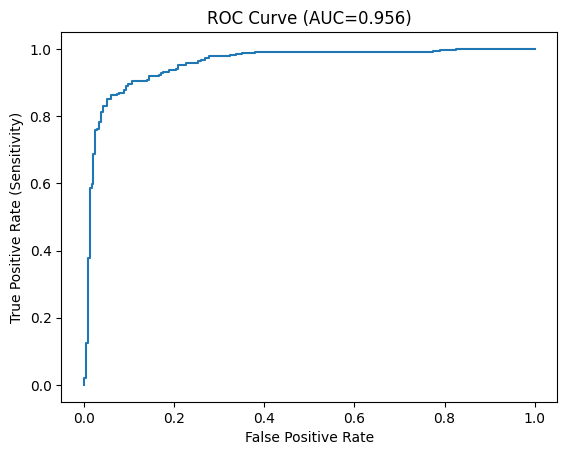

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

print("ROC AUC:", round(float(auc), 4))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title(f"ROC Curve (AUC={auc:.3f})")
plt.show()


In [9]:
import numpy as np

target_sens = 0.95

idx = np.where(tpr >= target_sens)[0]

if len(idx) == 0:
    print("No threshold achieves target sensitivity on this set.")
else:
    i = idx[0]
    chosen_thresh = thresholds[i]
    achieved_sens = tpr[i]
    achieved_fpr = fpr[i]

    print("Chosen threshold:", float(chosen_thresh))
    print("Achieved sensitivity:", float(achieved_sens))
    print("Achieved FPR:", float(achieved_fpr))


Chosen threshold: 0.5094203352928162
Achieved sensitivity: 0.9512820512820512
Achieved FPR: 0.2094017094017094


In [10]:
from sklearn.metrics import confusion_matrix

y_pred = (y_prob >= chosen_thresh).astype(int)
cm = confusion_matrix(y_true, y_pred)

TN, FP = cm[0]
FN, TP = cm[1]

sensitivity = TP / (TP + FN) if (TP + FN) else 0
specificity = TN / (TN + FP) if (TN + FP) else 0

print("Confusion matrix [[TN FP],[FN TP]]:")
print(cm)
print(f"Sensitivity: {sensitivity*100:.2f}%")
print(f"Specificity: {specificity*100:.2f}%")


Confusion matrix [[TN FP],[FN TP]]:
[[185  49]
 [ 19 371]]
Sensitivity: 95.13%
Specificity: 79.06%


In [11]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_true, y_prob)
print("Brier score:", round(float(brier), 5))


Brier score: 0.09187


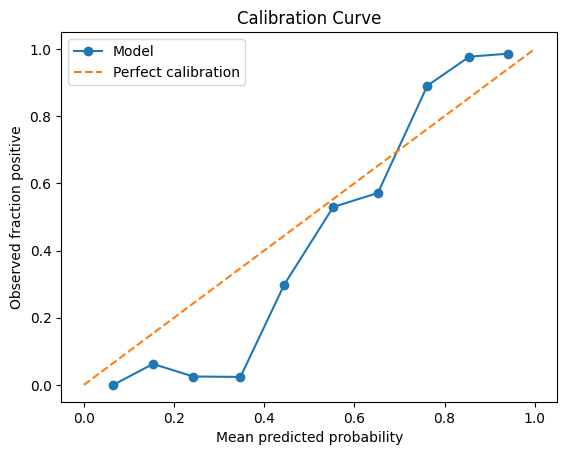

In [12]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

frac_pos, mean_pred = calibration_curve(
    y_true, y_prob, n_bins=10, strategy="uniform"
)

plt.figure()
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction positive")
plt.title("Calibration Curve")
plt.legend()
plt.show()


In [13]:
import torch
import torch.nn.functional as F

# Containers for activations and gradients
activations = {}
gradients = {}

def forward_hook(module, inp, out):
    activations["value"] = out

def backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0]

# Register hooks
target_layer = model.features.denseblock4
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_backward_hook(backward_hook)

print("Grad-CAM hooks registered")


Grad-CAM hooks registered


In [14]:
# Get one batch from test_loader
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Choose an index (0 is fine)
idx = 0
input_img = images[idx:idx+1]
true_label = labels[idx].item()

print("True label:", test_dataset.classes[true_label])


True label: NORMAL


In [15]:
model.zero_grad()
model.eval()

# Forward
logits = model(input_img)
probs = torch.softmax(logits, dim=1)
pred_class = probs.argmax(dim=1).item()

# Backward on the predicted class score
score = logits[0, pred_class]
score.backward()

print("Predicted label:", test_dataset.classes[pred_class])


C:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted label: NORMAL


In [16]:
# Remove old hooks if they exist
try:
    fh.remove()
    bh.remove()
except Exception:
    pass

activations = {}
gradients = {}

def forward_hook(module, inp, out):
    activations["value"] = out

def full_backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0]

target_layer = model.features.denseblock4
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_full_backward_hook(full_backward_hook)

print("Grad-CAM hooks registered (full backward hook)")


RuntimeError: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Data
DATA_ROOT = r"C:\Users\dell\medical_ai_diagnosis\data\kaggle_cxr\chest_xray\chest_xray"
test_dataset = ImageFolder(os.path.join(DATA_ROOT, "test"), transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Model
model = models.densenet121(weights=None)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
model.load_state_dict(torch.load("densenet_cxr_pneumonia.pt", map_location=device))
model = model.to(device)
model.eval()

print("Model + test_loader restored")


Model + test_loader restored


In [2]:
import torch.nn.functional as F

activations = {}
gradients = {}

def forward_hook(module, inp, out):
    activations["value"] = out

def full_backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0]

target_layer = model.features.denseblock4
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_full_backward_hook(full_backward_hook)

print("Grad-CAM full hooks registered")


Grad-CAM full hooks registered


In [3]:
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

idx = 0
input_img = images[idx:idx+1]
true_label = labels[idx].item()

model.zero_grad()
logits = model(input_img)
probs = torch.softmax(logits, dim=1)
pred_class = probs.argmax(dim=1).item()

score = logits[0, pred_class]
score.backward()

acts = activations["value"]
grads = gradients["value"]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)

cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)

cam = cam.squeeze().detach().cpu().numpy()

print("True:", test_dataset.classes[true_label])
print("Pred:", test_dataset.classes[pred_class])
print("CAM shape:", cam.shape)


True: NORMAL
Pred: NORMAL
CAM shape: (7, 7)


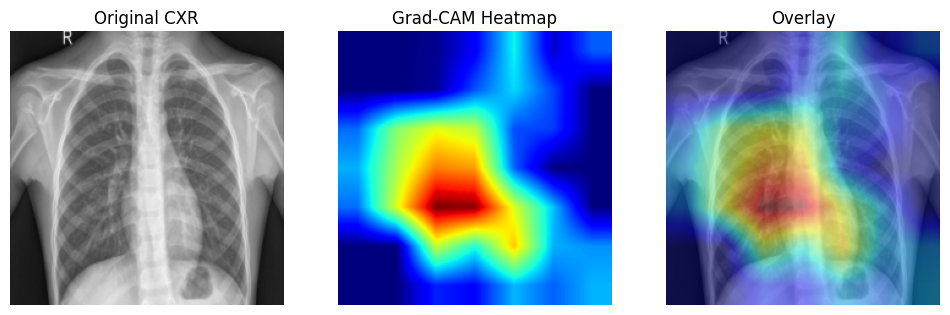

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# 1) Prepare the image for display (de-normalize)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

img = input_img * std + mean
img = img.squeeze(0).detach().cpu().permute(1,2,0).numpy()
img = np.clip(img, 0, 1)

# 2) Upsample CAM (7x7 -> 224x224)
cam_t = torch.tensor(cam).unsqueeze(0).unsqueeze(0)  # [1,1,7,7]
cam_up = F.interpolate(cam_t, size=(224, 224), mode="bilinear", align_corners=False)
cam_up = cam_up.squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original CXR")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam_up, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(cam_up, cmap="jet", alpha=0.45)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [5]:
# Find first pneumonia sample in test set
pneumonia_idx = None
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label == 1:  # 1 = PNEUMONIA
        pneumonia_idx = i
        break

pneumonia_idx


234

In [6]:
from torch.utils.data import DataLoader

# Load the specific pneumonia image
img, label = test_dataset[pneumonia_idx]

input_img = img.unsqueeze(0).to(device)
true_label = label

print("True label:", test_dataset.classes[true_label])


True label: PNEUMONIA


In [7]:
model.zero_grad()
model.eval()

logits = model(input_img)
probs = torch.softmax(logits, dim=1)
pred_class = probs.argmax(dim=1).item()

score = logits[0, pred_class]
score.backward()

print("Predicted label:", test_dataset.classes[pred_class])
print("Predicted probability:", float(probs[0, pred_class]))


Predicted label: PNEUMONIA
Predicted probability: 0.5963393449783325


C:\Users\dell\AppData\Local\Temp\ipykernel_14264\866363884.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  print("Predicted probability:", float(probs[0, pred_class]))


In [8]:
import torch.nn.functional as F

acts = activations["value"]
grads = gradients["value"]

weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)

cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)

cam = cam.squeeze().detach().cpu().numpy()
print("CAM shape:", cam.shape)


CAM shape: (7, 7)


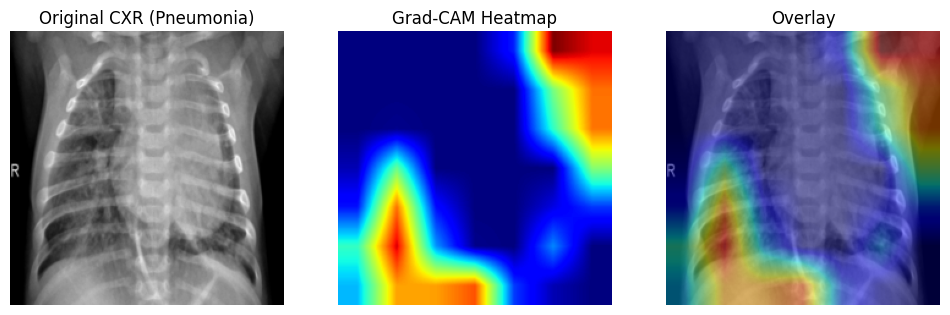

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# De-normalize image
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

img_disp = input_img * std + mean
img_disp = img_disp.squeeze(0).detach().cpu().permute(1,2,0).numpy()
img_disp = np.clip(img_disp, 0, 1)

# Upsample CAM
cam_t = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
cam_up = F.interpolate(cam_t, size=(224,224), mode="bilinear", align_corners=False)
cam_up = cam_up.squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_disp)
plt.title("Original CXR (Pneumonia)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam_up, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_disp)
plt.imshow(cam_up, cmap="jet", alpha=0.45)
plt.title("Overlay")
plt.axis("off")

plt.show()
